In [7]:
import kagglehub
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /home/syarnaq/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


Number of TRAIN Normal images: 1341
Number of TRAIN Pneumonia images: 3875
Number of TEST Normal images: 234
Number of TEST Pneumonia images: 390


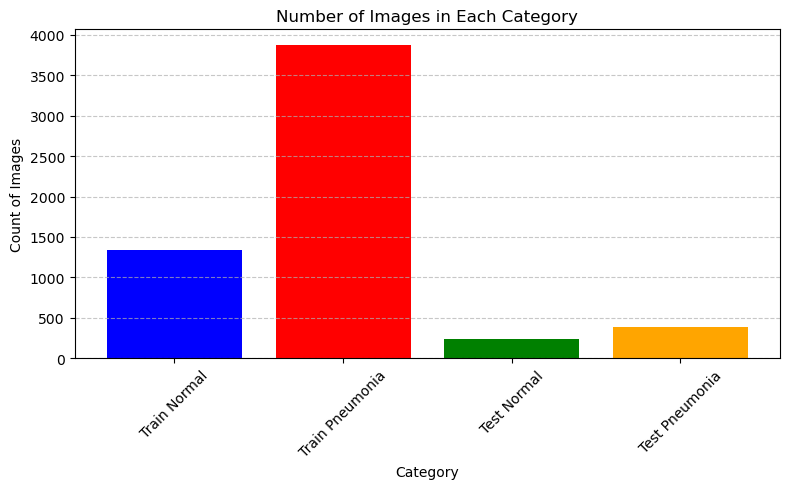

In [8]:
# Path to your dataset directory
dataset_path = os.path.join(path, "chest_xray")

# Directories for training data
train_normal_dir = os.path.join(dataset_path, 'train', 'NORMAL')
train_pneumonia_dir = os.path.join(dataset_path, 'train', 'PNEUMONIA')

# Directories for testing data
test_normal_dir = os.path.join(dataset_path, 'test', 'NORMAL')
test_pneumonia_dir = os.path.join(dataset_path, 'test', 'PNEUMONIA')

# Count the images
train_normal_count = len(os.listdir(train_normal_dir))
train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
test_normal_count = len(os.listdir(test_normal_dir))
test_pneumonia_count = len(os.listdir(test_pneumonia_dir))

print("Number of TRAIN Normal images:", train_normal_count)
print("Number of TRAIN Pneumonia images:", train_pneumonia_count)
print("Number of TEST Normal images:", test_normal_count)
print("Number of TEST Pneumonia images:", test_pneumonia_count)

# Prepare data for bar chart
labels = ['Train Normal', 'Train Pneumonia', 'Test Normal', 'Test Pneumonia']
counts = [train_normal_count, train_pneumonia_count, test_normal_count, test_pneumonia_count]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['blue', 'red', 'green', 'orange'])
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


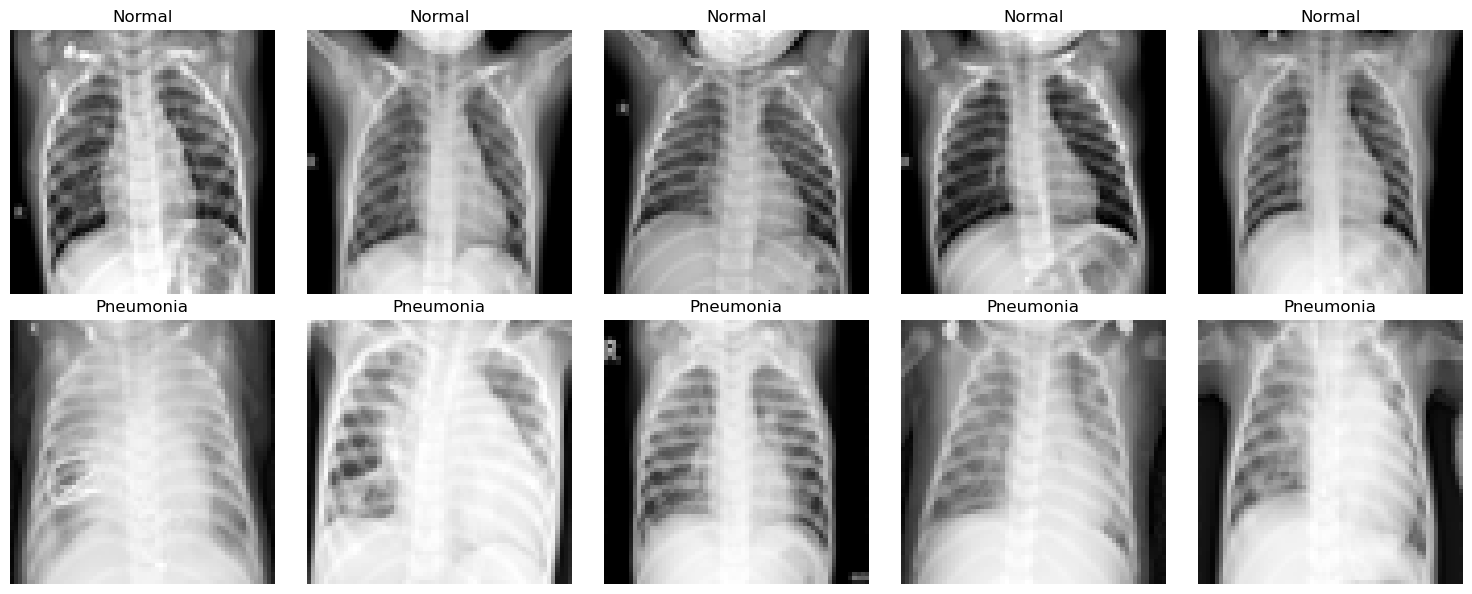

In [9]:
# Get a list of image file names from each class
normal_images = [os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir) if f.lower().endswith('.jpeg')]
pneumonia_images = [os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir) if f.lower().endswith('.jpeg')]

# Select the first 5 images from each class
normal_examples = normal_images[:5]
pneumonia_examples = pneumonia_images[:5]

# Desired size
target_size = (64, 64)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the normal images
for i, img_path in enumerate(normal_examples):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to 64x64
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Normal")

# Plot the pneumonia images
for i, img_path in enumerate(pneumonia_examples):
    img = Image.open(img_path)
    img = img.resize(target_size)  # Resize to 64x64
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Pneumonia")

plt.tight_layout()
plt.show()

In [10]:
latent_dim = 100  # Size of the noise vector
batch_size = 64
image_size = 64   # Height/Width of the images
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5
channels_img = 1

In [12]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

root = os.path.join(dataset_path,"train")
dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g=64):
        super(Generator, self).__init__()
        # features_g is a base channel size, commonly 64 for DCGAN on 64x64 images

        self.main = nn.Sequential(
            # Input: N x latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, features_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(True),
            # State: N x (features_g*8) x 4 x 4

            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(True),
            # State: N x (features_g*4) x 8 x 8

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(True),
            # State: N x (features_g*2) x 16 x 16

            nn.ConvTranspose2d(features_g*2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),
            # State: N x features_g x 32 x 32

            nn.ConvTranspose2d(features_g, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
            # State: N x channels_img x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x features_d x 32 x 32

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (features_d*2) x 16 x 16

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (features_d*4) x 8 x 8

            nn.Conv2d(features_d*4, features_d*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: N x (features_d*8) x 4 x 4

            nn.Conv2d(features_d*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # State: N x 1 x 1 x 1 (scalar output)
        )

    def forward(self, x):
        return self.main(x)

In [15]:
G = Generator(latent_dim, channels_img).to(device)
D = Discriminator(channels_img).to(device)

# Initialize weights according to DCGAN paper
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

optimizerG = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, 0.999))

criterion = nn.BCELoss()

In [16]:
G.train()
D.train()

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)

        # Labels
        real_label = torch.ones(batch_size, device=device)
        fake_label = torch.zeros(batch_size, device=device)

        # ---------------------------
        # Train Discriminator
        # ---------------------------
        # Real images
        D.zero_grad()
        output = D(real).view(-1)
        lossD_real = criterion(output, real_label)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = G(noise)
        output = D(fake.detach()).view(-1)  # detach so G isn’t updated here
        lossD_fake = criterion(output, fake_label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---------------------------
        # Train Generator
        # ---------------------------
        G.zero_grad()
        output = D(fake).view(-1)
        lossG = criterion(output, real_label)  # We want fake to be classified as real
        lossG.backward()
        optimizerG.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

Epoch [0/50] Batch 0/82                   Loss D: 1.7163, Loss G: 3.6856
Epoch [1/50] Batch 0/82                   Loss D: 0.3136, Loss G: 3.9452
Epoch [2/50] Batch 0/82                   Loss D: 0.3636, Loss G: 6.0384
Epoch [3/50] Batch 0/82                   Loss D: 0.0984, Loss G: 5.0282
Epoch [4/50] Batch 0/82                   Loss D: 0.6894, Loss G: 2.7544
Epoch [5/50] Batch 0/82                   Loss D: 0.4578, Loss G: 5.2732
Epoch [6/50] Batch 0/82                   Loss D: 0.5906, Loss G: 4.8665
Epoch [7/50] Batch 0/82                   Loss D: 0.2302, Loss G: 4.7390
Epoch [8/50] Batch 0/82                   Loss D: 0.2793, Loss G: 6.0821
Epoch [9/50] Batch 0/82                   Loss D: 0.3457, Loss G: 4.4462
Epoch [10/50] Batch 0/82                   Loss D: 0.3516, Loss G: 3.7867
Epoch [11/50] Batch 0/82                   Loss D: 0.4388, Loss G: 5.4782
Epoch [12/50] Batch 0/82                   Loss D: 0.4826, Loss G: 7.1093
Epoch [13/50] Batch 0/82                   Loss 

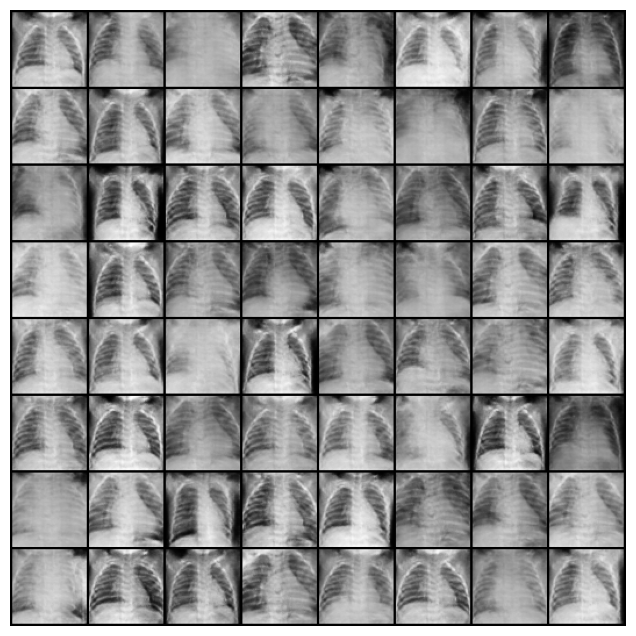

In [21]:
G.eval()
with torch.no_grad():
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    fake_images = G(fixed_noise).cpu()  # shape [64, 1, 64, 64]
    # Denormalize if needed: fake_images = fake_images * 0.5 + 0.5
    grid = torchvision.utils.make_grid(fake_images, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).detach().numpy())
    plt.axis('off')
    plt.show()